### Importing and formatting data

In [73]:
import neo
reader = neo.io.BlackrockIO("/Users/maxtenenbaum/Desktop/Code/Deku Lab Neural Data Analysis/deku_ephys/data/raw/IO16RY_011.ns3")
block = reader.read_block()

In [74]:
print("Number of segments:", len(block.segments))
for i, seg in enumerate(block.segments):
    print("Segment", i)
    print("  Number of analog signals:", len(seg.analogsignals))
    print("  Number of spike trains:", len(seg.spiketrains))
    print("  Number of events:", len(seg.events))


Number of segments: 1
Segment 0
  Number of analog signals: 1
  Number of spike trains: 0
  Number of events: 3


### Extracting signal and getting metadata

In [77]:
signal = block.segments[0].analogsignals[0]

signal

AnalogSignal with 16 channels of length 60004; units uV; datatype float32 
name: 'nsx3'
description: 'AnalogSignal from  nsx3'
annotations: {'stream_id': '3', 'nsx': 3}
sampling rate: 2000.0 Hz
time: 2198.748 s to 2228.75 s

In [78]:
signal.shape

(60004, 16)

### Plotting raw data

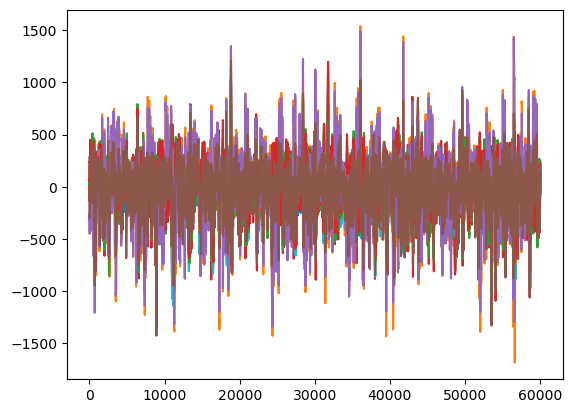

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(signal)), signal)

### Plotting formatted raw data

In [80]:
import numpy as np
num_channels = signal.shape[1]
time_vector = np.arange(len(signal))/2000

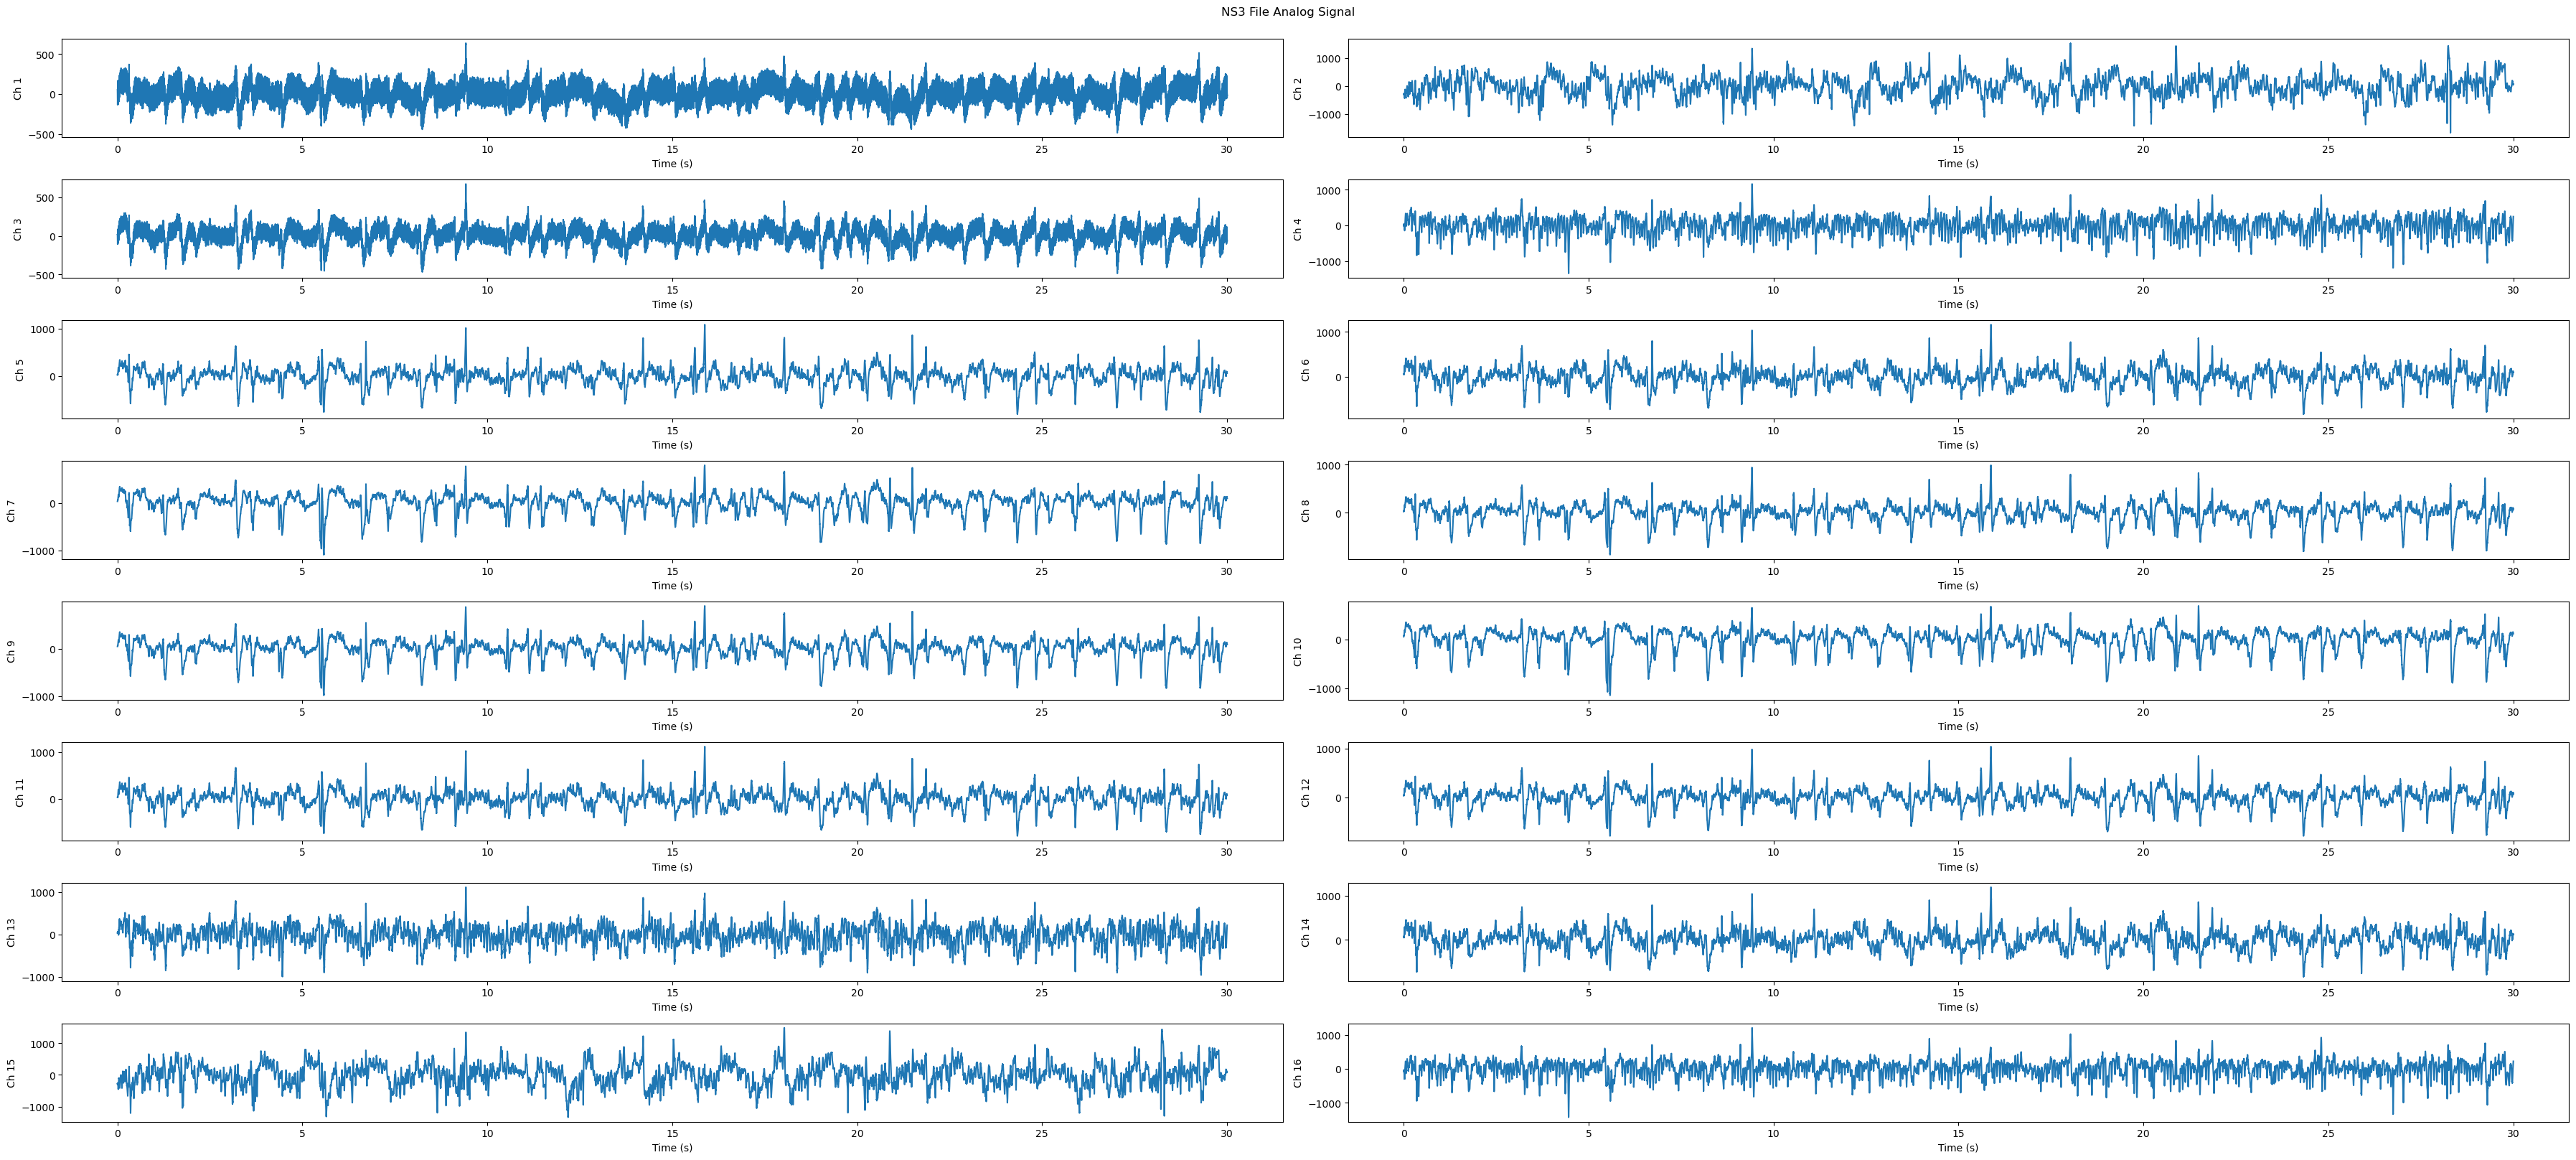

In [81]:
plt.figure(figsize=(36, num_channels*2))
for i in range(num_channels):
    plt.subplot(num_channels, 2, i+1)
    plt.plot(time_vector, signal[:, i])
    plt.ylabel(f"Ch {i+1}")
    plt.xlabel("Time (s)")

plt.suptitle("NS3 File Analog Signal")
plt.tight_layout(rect=[0,0, 1, 0.98])


### Overlaying channels of interest on top of averages

In [83]:
average_signal = signal[:,0]
for i in range(1, num_channels):
    if i != 5:
        average_signal += signal[:,i]
    if i == 5:
        pass

average_signal = average_signal/num_channels

    

In [84]:
chans_of_interest = [average_signal, signal[:,5]]

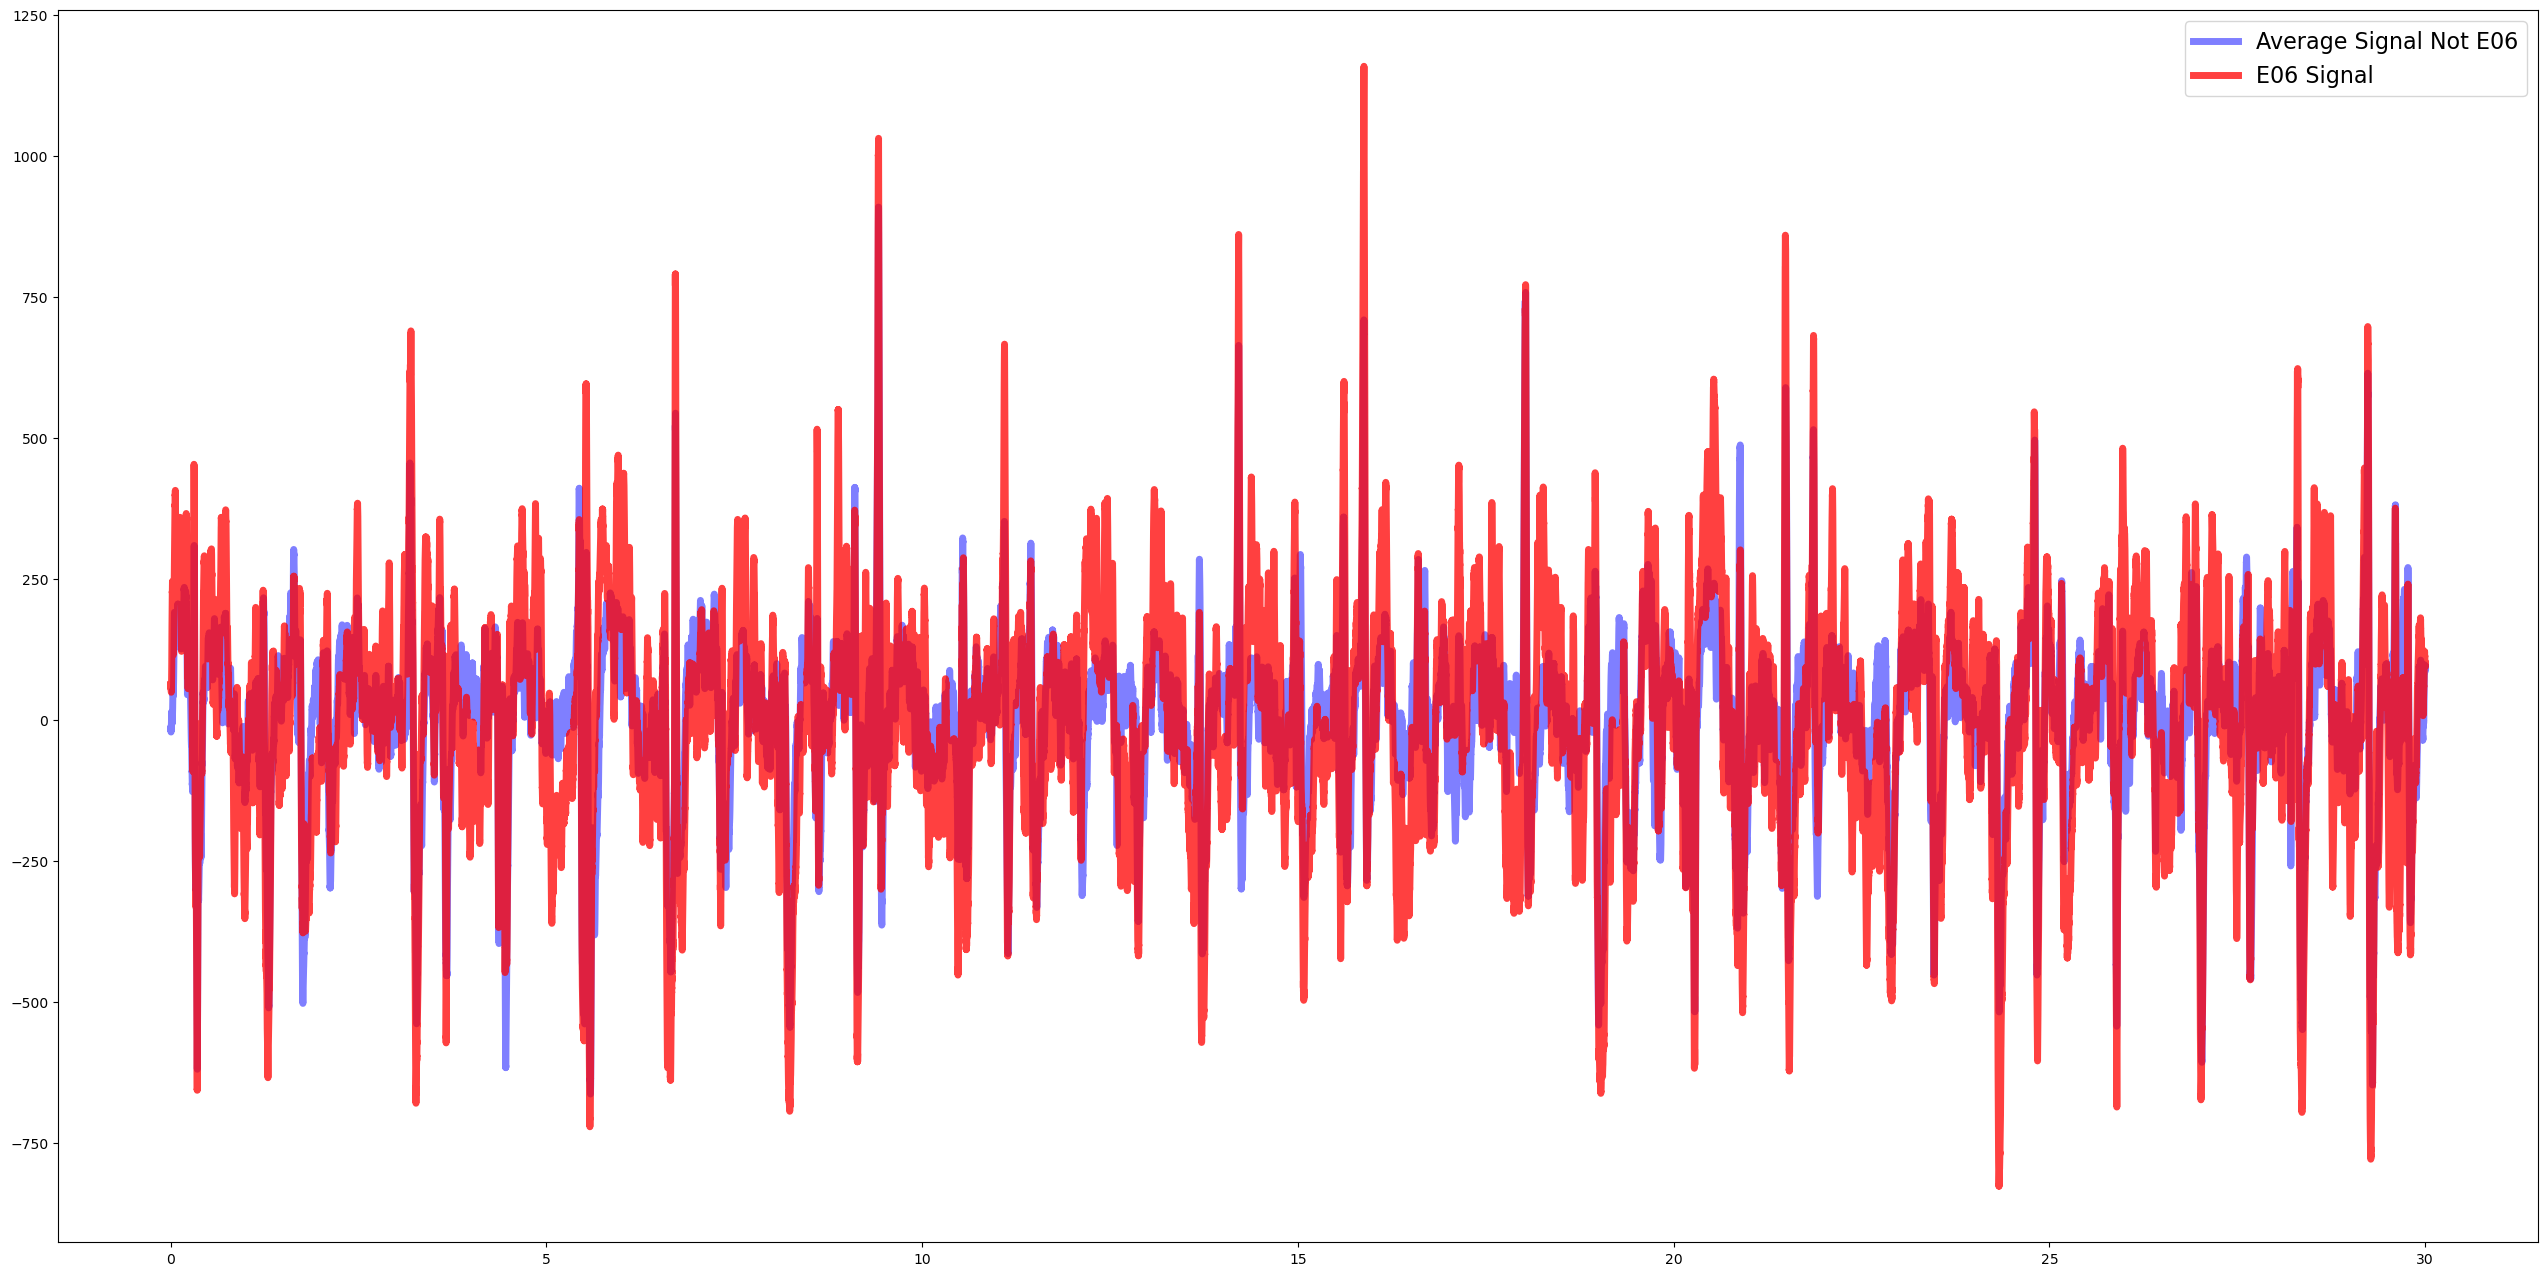

In [85]:
plt.figure(figsize=(32,16))
plt.plot(time_vector, average_signal, color="blue", label="Average Signal Not E06", linewidth=5, alpha=0.5)
plt.plot(time_vector, signal[:,5], color="red", label="E06 Signal", linewidth=5, alpha=0.75)
plt.legend(prop={'size': 16})

### Downsampling for better visibility

In [86]:
from scipy.signal import resample

In [87]:
# Setting downsample variables
original_frequency = 2000
downsampledfreq = 10
num_samples = int((len(signal) * downsampledfreq)/original_frequency)
print(num_samples)

300


In [88]:
downsampled_signal = resample(signal, num_samples)
downsampled_vector = np.arange(len(downsampled_signal))/downsampledfreq

In [89]:
downsampled_average = downsampled_signal[:,0]
for i in range(1, num_channels):
    if i != 5:
        downsampled_average += downsampled_signal[:,i]
    if i == 5:
        pass

downsampled_average = downsampled_average/num_channels

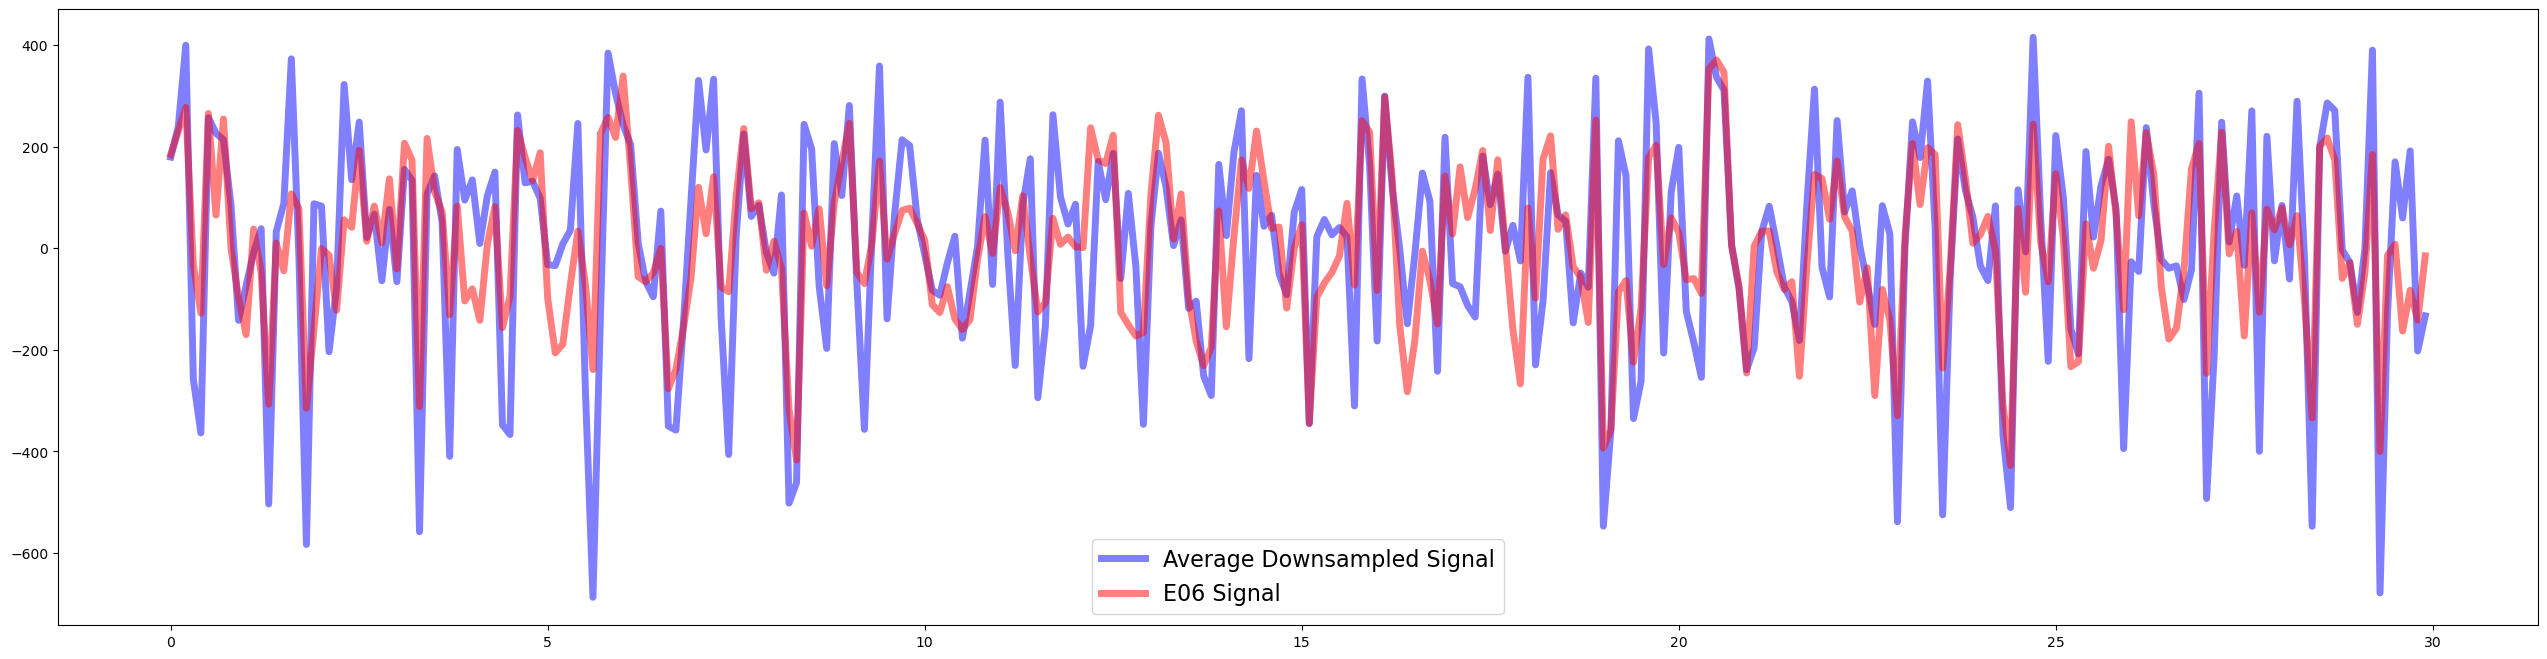

In [90]:
plt.figure(figsize=(32,8))
plt.plot(downsampled_vector, downsampled_average, color="blue", label="Average Downsampled Signal", linewidth=5, alpha=0.5)
plt.plot(downsampled_vector, downsampled_signal[:,5], color="red", label="E06 Signal", linewidth=5, alpha=0.5)
plt.legend(prop={"size":16})

### Correlation Matrix to show similarity across signals

In [ ]:
correlation_matrix = np.corrcoef(signal.T)

In [ ]:
x = [i for i in range(correlation_matrix.shape[0])]

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Linear Correlation Matrix')
plt.xticks(ticks=x, labels=[str(i+1) for i in x])
plt.yticks(ticks=x, labels=[str(i+1) for i in x])
plt.show()

### PCA

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(signal.T)

# Create a scatter plot with improved aesthetics
plt.figure(figsize=(12, 10))

# Create a colormap for the channels
colors = plt.cm.viridis(np.linspace(0, 1, num_channels))

# Plot the PCA results
for i in range(num_channels):
    plt.scatter(pca_result[i, 0], pca_result[i, 1], color=colors[i], s=100, label=f'Ch {i+1}')
    plt.annotate(f'Ch {i+1}',
                 xy=(pca_result[i, 0], pca_result[i, 1]), 
                 xytext=(10, 10),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', color='black'),
                 fontsize=9,
                 ha='right')

plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.title('PCA of Unfiltered Analog Signal', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12, title="Channels")
plt.grid(True)
plt.show()

### Euclidian Distance for Dissimilarity

In [ ]:
from scipy.spatial.distance import pdist, squareform

distance_matrix = squareform(pdist(signal.T, metric='euclidean'))

plt.figure(figsize=(10, 8))
plt.imshow(distance_matrix, cmap='plasma', interpolation='none')
plt.colorbar()
plt.xticks(ticks=x, labels=[str(i+1) for i in x])
plt.yticks(ticks=x, labels=[str(i+1) for i in x])
plt.title('Euclidean Distance Matrix')
plt.show()


### Spectral Power Estimation

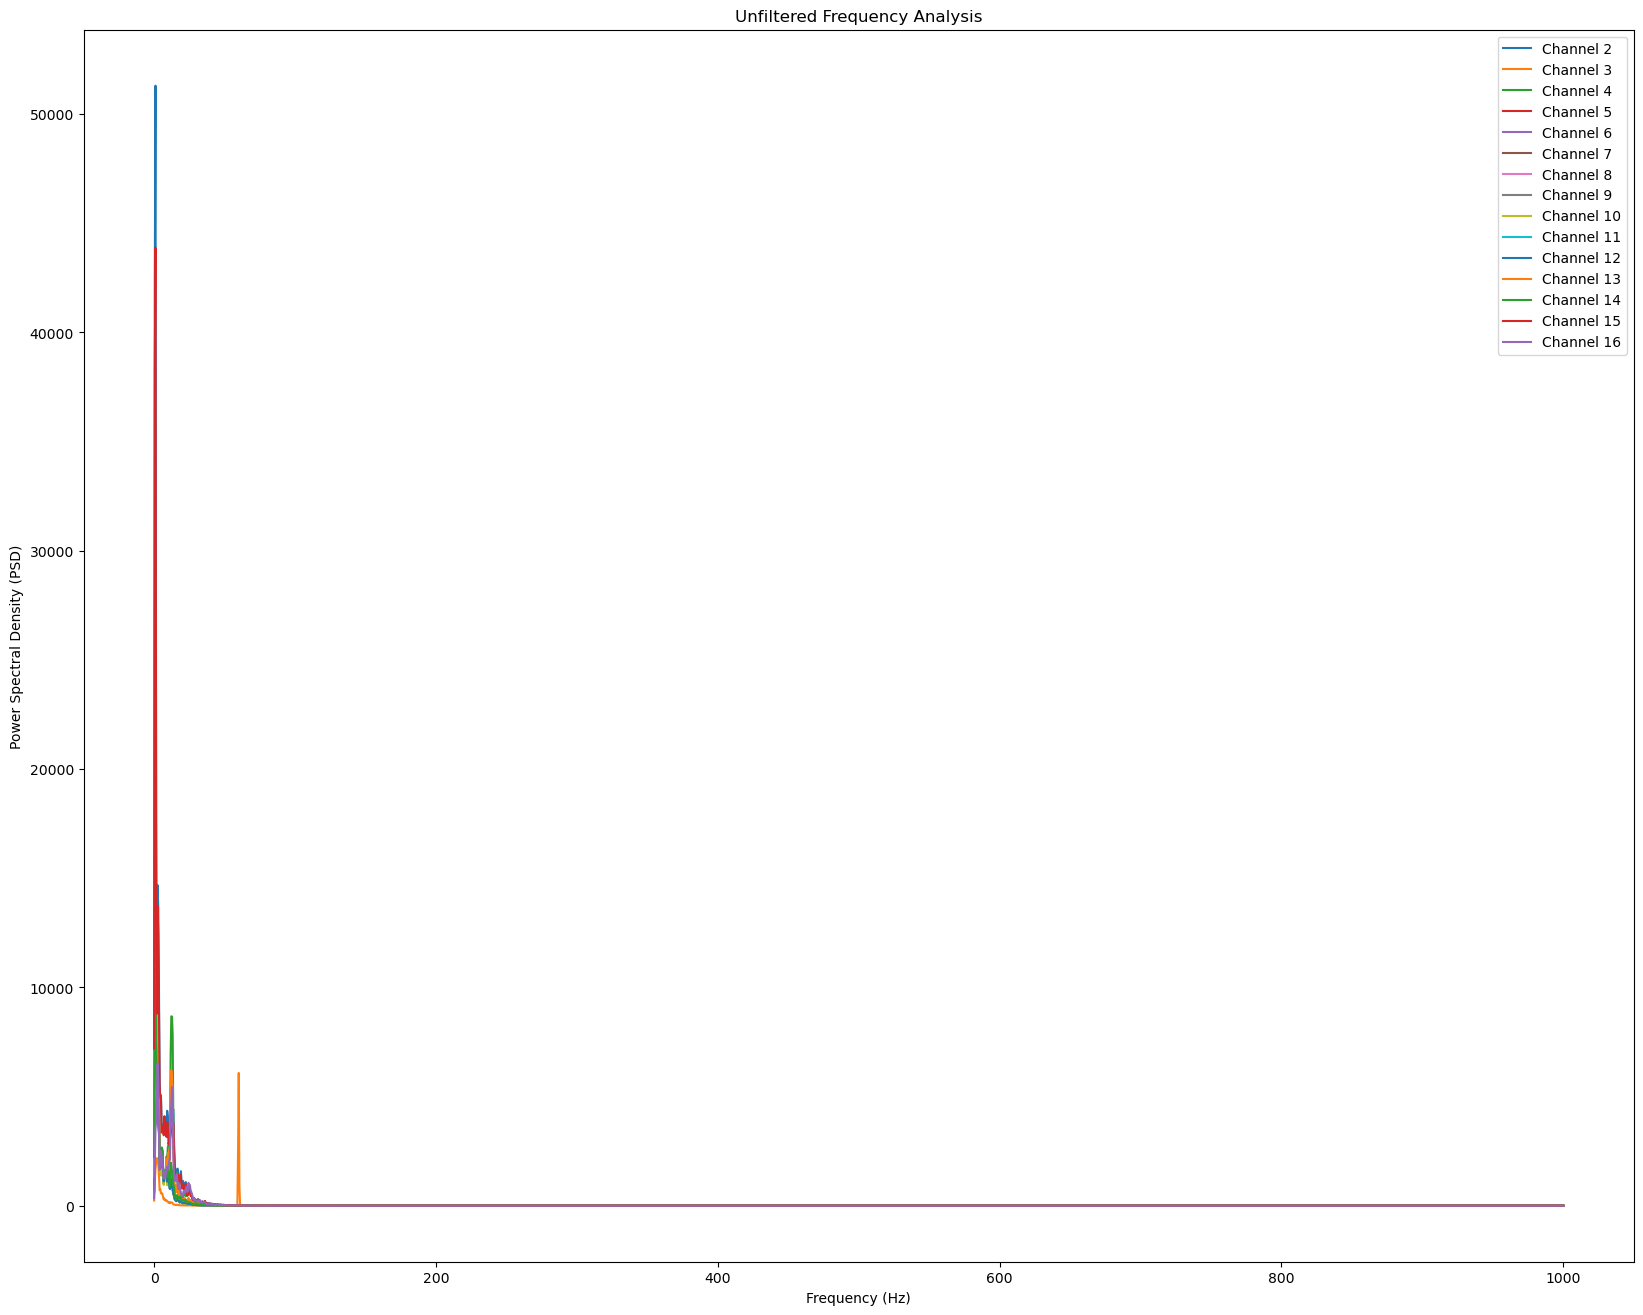

In [94]:
from scipy.signal import welch
fs = 2000 
frequencies, psd = welch(signal, fs, nperseg=4096, axis=0)

plt.figure(figsize=(20, 16))
for i in range(1,signal.shape[1]):
    plt.plot(frequencies, psd[:, i], label=f'Channel {i+1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (PSD)')
plt.title('Unfiltered Frequency Analysis')
plt.legend()
plt.show()

It becomes clear here that there are some artifacts, specifically in the frequencies of 0-2Hz. I will highpass these and check the correlation and dissimilarity again.